###  Energy Generation Time Series
##### U.S. Electricity Generation (https://www.kaggle.com/datasets/ravishah1/electricity-generation-time-series)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import preprocessing
import warnings
warnings.simplefilter("ignore", UserWarning)
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn 
import torch.nn.functional as F


In [2]:
us_el=pd.read_csv('electricity_data.csv')

In [3]:
us_el.head()

,Unnamed: 0,United States : all sectors,United States : electric utility,United States : independent power producers,United States : all commercial,United States : all industrial,New England : all sectors,New England : electric utility,New England : independent power producers,New England : all commercial,...,Alaska : all sectors,Alaska : electric utility,Alaska : independent power producers,Alaska : all commercial,Alaska : all industrial,Hawaii : all sectors,Hawaii : electric utility,Hawaii : independent power producers,Hawaii : all commercial,Hawaii : all industrial
0,2001-01-01,332493,236467,82269,629,13128,10005,2467,6959,68,...,590,493,20,10,67,925,524,320,--,81
1,2001-02-01,282940,199802,71169,548,11421,8662,2289,5873,65,...,546,423,22,18,84,801,457,293,--,51
2,2001-03-01,300707,211942,75758,553,12454,9506,2061,6882,70,...,587,459,23,18,88,873,573,254,--,46
3,2001-04-01,278079,197499,68356,550,11674,8321,1711,6096,70,...,489,402,17,9,61,836,522,278,--,36
4,2001-05-01,300492,215508,72658,575,11751,8592,1372,6677,72,...,485,395,16,8,65,886,539,310,--,37


In [4]:
us_el = us_el.loc[:,: "United States : all industrial"]

In [5]:
us_el.head()

,Unnamed: 0,United States : all sectors,United States : electric utility,United States : independent power producers,United States : all commercial,United States : all industrial
0,2001-01-01,332493,236467,82269,629,13128
1,2001-02-01,282940,199802,71169,548,11421
2,2001-03-01,300707,211942,75758,553,12454
3,2001-04-01,278079,197499,68356,550,11674
4,2001-05-01,300492,215508,72658,575,11751


In [12]:
len(us_el)

255

In [6]:
us_el.describe()

,United States : all sectors,United States : electric utility,United States : independent power producers,United States : all commercial,United States : all industrial
count,255.000000,255.000000,255.000000,255.000000,255.000000
mean,336775.325490,199710.415686,124076.913725,868.196078,12119.749020
std,34285.028716,22537.943591,20354.042729,212.204869,789.382815
min,278079.000000,146843.000000,68356.000000,500.000000,9910.000000
25%,309887.000000,182854.500000,111712.000000,675.000000,11588.500000
50%,327936.000000,197136.000000,125381.000000,867.000000,12143.000000
75%,357726.000000,215458.000000,137738.500000,1051.500000,12701.500000
max,421797.000000,258901.000000,170617.000000,1318.000000,13926.000000


In [8]:
us_el.isna().sum()

Unnamed: 0                                     0
United States : all sectors                    0
United States : electric utility               0
United States : independent power producers    0
United States : all commercial                 0
United States : all industrial                 0
dtype: int64

In [9]:

us_el.rename(columns={'Unnamed: 0':'Date'}, inplace = True)
us_el['Date']=pd.to_datetime(us_el['Date'])

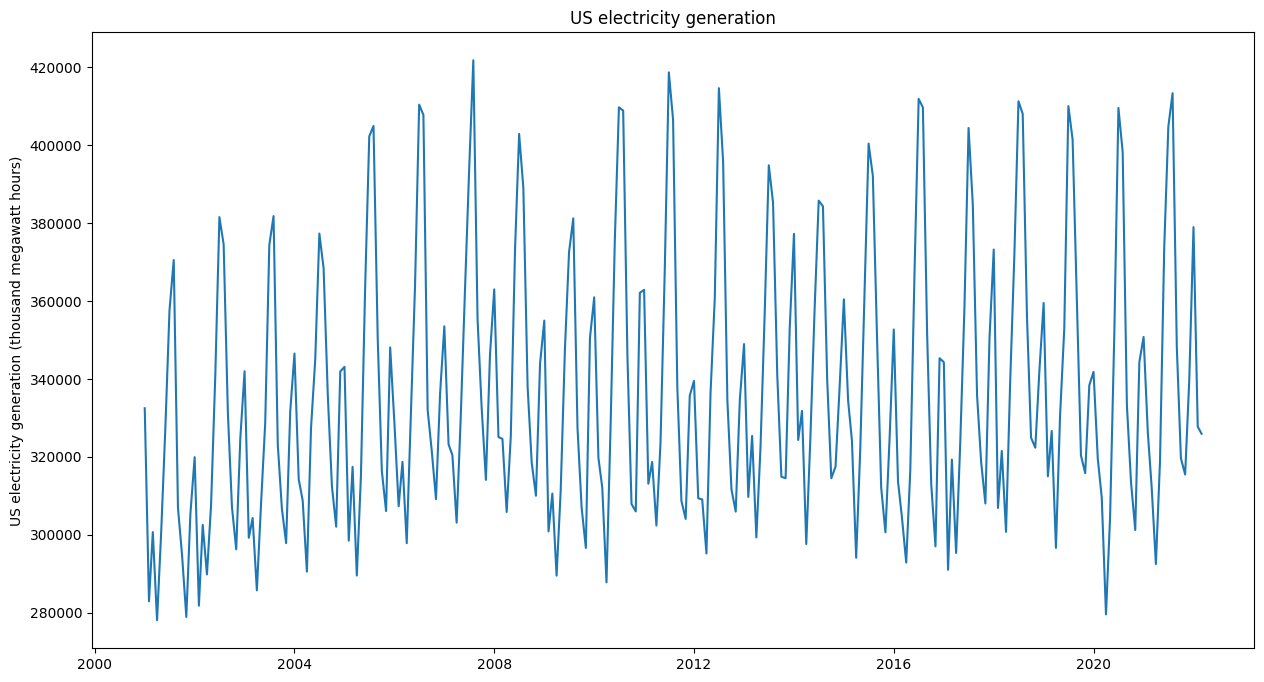

In [58]:
plt.figure(figsize=(15,8))
plt.plot(us_el['Date'], us_el["United States : all sectors"])
plt.title('US electricity generation')
plt.ylabel('US electricity generation (thousand megawatt hours)')
plt.show();

In [13]:
us_el_selected = us_el.loc[:,:'United States : all sectors']

In [14]:
us_el_selected.head()

,Date,United States : all sectors
0,2001-01-01,332493
1,2001-02-01,282940
2,2001-03-01,300707
3,2001-04-01,278079
4,2001-05-01,300492


In [15]:
us_el_selected.set_index('Date', inplace=True)

In [16]:
def split(df):
    split_id = int(len(us_el_selected)*0.8)
    train = us_el_selected["United States : all sectors"].values.astype(float)[:split_id]
    test = us_el_selected["United States : all sectors"].values.astype(float)[split_id:]
    return train, test

In [17]:

def create_seq (data, windows, future):
    x, y = [],[]
    for i in range(len(data)-windows):
        features = data[i:i+windows]
        x.append(features)
        target = data[i+windows]
        y.append(target)
    return x, y

In [18]:
train, test =split(us_el_selected)
min_max_scaler=preprocessing.MinMaxScaler()
train =min_max_scaler.fit_transform(train.reshape(-1, 1))
test = min_max_scaler.transform(test.reshape(-1, 1))
windows= 5
x_train, y_train = create_seq(train,windows,1)
x_test, y_test = create_seq(test,windows,1)

In [19]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [21]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        # self.y = torch.tensor(y, dtype=torch.float32).clone().reshape([-1,5])
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [22]:
batch_size = 8
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [23]:
class LSTMTimeSeries(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, future):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.future = future
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x): 
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [24]:
model = LSTMTimeSeries(input_size=1, hidden_size=256, num_layers=2, future=1)

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [26]:
num_epochs =10
avg_loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y in trainloader:
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        avg_loss.append(loss.detach().numpy())
print(avg_loss)

[array(0.3296519, dtype=float32), array(0.32598576, dtype=float32), array(0.35379344, dtype=float32), array(0.11182925, dtype=float32), array(0.15523405, dtype=float32), array(0.15867642, dtype=float32), array(0.19059134, dtype=float32), array(0.10931434, dtype=float32), array(0.0358564, dtype=float32), array(0.19409698, dtype=float32), array(0.05258422, dtype=float32), array(0.10463455, dtype=float32), array(0.02240338, dtype=float32), array(0.12955546, dtype=float32), array(0.17632465, dtype=float32), array(0.03071778, dtype=float32), array(0.1092177, dtype=float32), array(0.25754654, dtype=float32), array(0.04857938, dtype=float32), array(0.0370439, dtype=float32), array(0.07795072, dtype=float32), array(0.0616945, dtype=float32), array(0.06324553, dtype=float32), array(0.07793226, dtype=float32), array(0.04493492, dtype=float32), array(0.07161355, dtype=float32), array(0.03247469, dtype=float32), array(0.03736586, dtype=float32), array(0.1081949, dtype=float32), array(0.04259202, d

In [30]:
inverse_predictions = min_max_scaler.inverse_transform(np.array(predicted).reshape(-1, 1))
inverse_actual = min_max_scaler.inverse_transform(np.array(y_train).reshape(-1, 1))

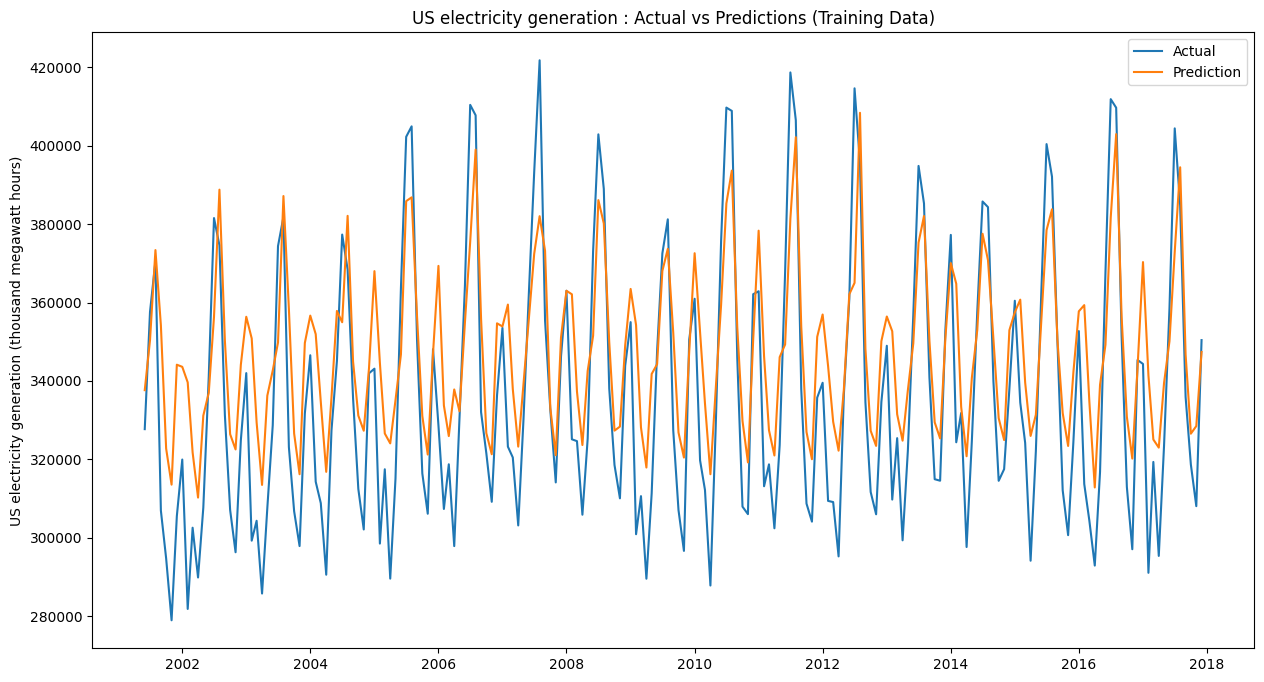

In [50]:

plt.figure(figsize=(15,8))
plt.plot(us_el_selected[5:204].index, inverse_actual, label='Actual')
plt.plot( us_el_selected[5:204].index, inverse_predictions, label='Prediction')
plt.title("US electricity generation : Actual vs Predictions (Training Data)")
plt.ylabel('US electricity generation (thousand megawatt hours)')
plt.legend()
plt.show()

In [33]:
model.eval()

num_epochs =10
avg_loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y in testloader:
        optimizer.zero_grad()
        test_predictions = model(x)
        loss = criterion(test_predictions, y)
        loss.backward()
        optimizer.step()
        avg_loss.append(loss.detach().numpy())

print(avg_loss)

[array(0.00501424, dtype=float32), array(0.00188031, dtype=float32), array(0.00203543, dtype=float32), array(0.00235633, dtype=float32), array(0.00197235, dtype=float32), array(0.00342481, dtype=float32), array(0.0026943, dtype=float32), array(0.00234497, dtype=float32), array(0.00281132, dtype=float32), array(0.00201685, dtype=float32), array(0.00375829, dtype=float32), array(0.00219303, dtype=float32), array(0.00177449, dtype=float32), array(0.0014696, dtype=float32), array(0.0018539, dtype=float32), array(0.00442395, dtype=float32), array(0.0020491, dtype=float32), array(0.00185491, dtype=float32), array(0.00154888, dtype=float32), array(0.00176911, dtype=float32), array(0.00330868, dtype=float32), array(0.00263162, dtype=float32), array(0.00223636, dtype=float32), array(0.0030705, dtype=float32), array(0.00142005, dtype=float32), array(0.00438551, dtype=float32), array(0.00214284, dtype=float32), array(0.00135231, dtype=float32), array(0.00134806, dtype=float32), array(0.00139725, 

In [34]:
with torch.no_grad():
    test_predicted = model(test_dataset.x.to(device)).to('cpu').numpy()

In [35]:
inverse_test_predictions = min_max_scaler.inverse_transform(np.array(test_predicted).reshape(-1, 1))
inverse_test_actual = min_max_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

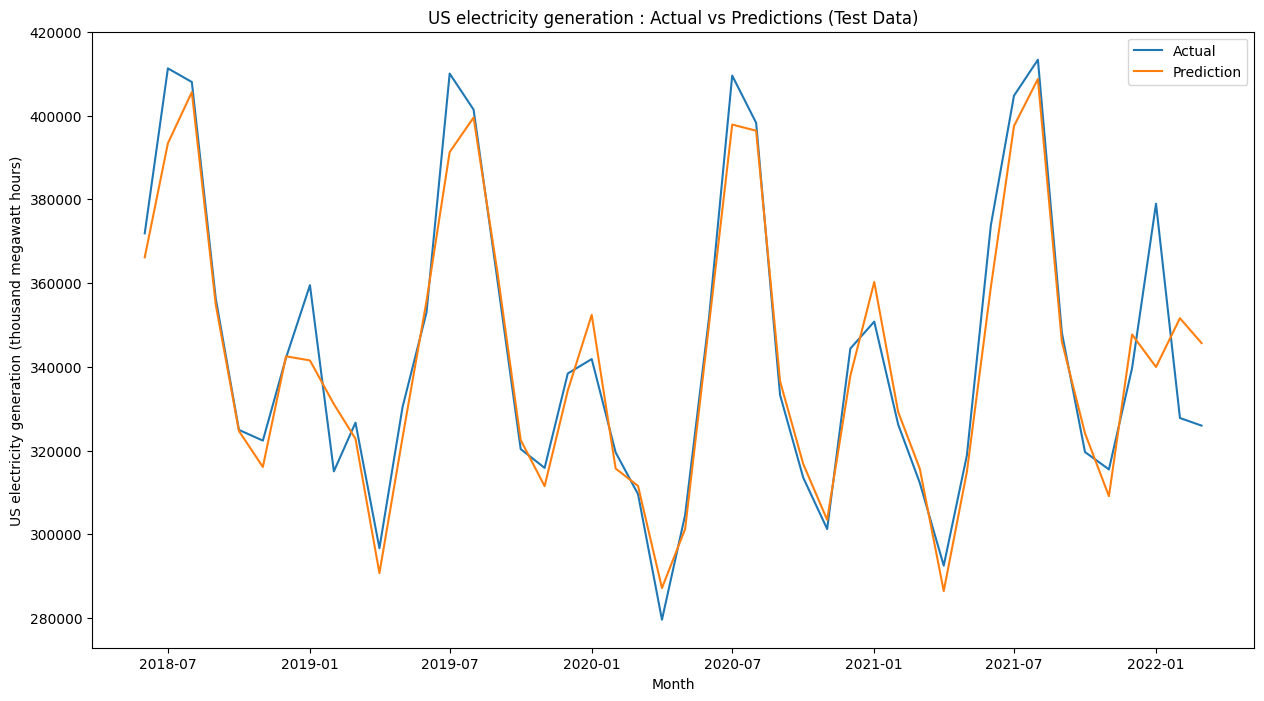

In [52]:
plt.figure(figsize=(15,8))
plt.plot(us_el_selected[209:].index, inverse_test_actual, label='Actual')
plt.plot( us_el_selected[209:].index, inverse_test_predictions, label='Prediction')
plt.title('US electricity generation : Actual vs Predictions (Test Data)')
plt.xlabel('Month')
plt.ylabel('US electricity generation (thousand megawatt hours)')
plt.legend()
plt.show()

In [38]:
all=us_el_selected["United States : all sectors"].values.astype(float)
min_max_scaler=preprocessing.MinMaxScaler()
all =min_max_scaler.fit_transform(all.reshape(-1, 1))
windows= 5
x, y = create_seq(all,windows,1)

In [39]:
all_dataset = TimeSeriesDataset(x, y)

In [40]:
batch_size = 8
allloader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [41]:
num_epochs =10
avg_loss = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y in allloader:
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        avg_loss.append(loss.detach().numpy())

print(avg_loss)

[array(0.00524414, dtype=float32), array(0.00811381, dtype=float32), array(0.00974885, dtype=float32), array(0.01425692, dtype=float32), array(0.00742972, dtype=float32), array(0.06383418, dtype=float32), array(0.01403462, dtype=float32), array(0.00810313, dtype=float32), array(0.00594113, dtype=float32), array(0.00967505, dtype=float32), array(0.01026281, dtype=float32), array(0.01499583, dtype=float32), array(0.01648618, dtype=float32), array(0.01165087, dtype=float32), array(0.00921054, dtype=float32), array(0.01298713, dtype=float32), array(0.01982789, dtype=float32), array(0.03558027, dtype=float32), array(0.03248531, dtype=float32), array(0.0160223, dtype=float32), array(0.00816551, dtype=float32), array(0.01003587, dtype=float32), array(0.00291165, dtype=float32), array(0.01766398, dtype=float32), array(0.02094129, dtype=float32), array(0.01547281, dtype=float32), array(0.00900776, dtype=float32), array(0.00792865, dtype=float32), array(0.04456813, dtype=float32), array(0.013666

In [42]:
future = 5 

future_pred = y[-windows:].flatten().tolist()
# print(pred_base.shape)
# x = torch.tensor(x, dtype=torch.float32)
model.eval()

for i in range(future):
    feature =  torch.tensor(future_pred[-windows:]).reshape([-1,5,1])
    with torch.no_grad():
        future_pred.append(model(feature).item())

In [43]:
inverse_future_pred = min_max_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

In [44]:
future_month = np.arange("2022-04-01","2022-09-01", dtype='datetime64[M]')

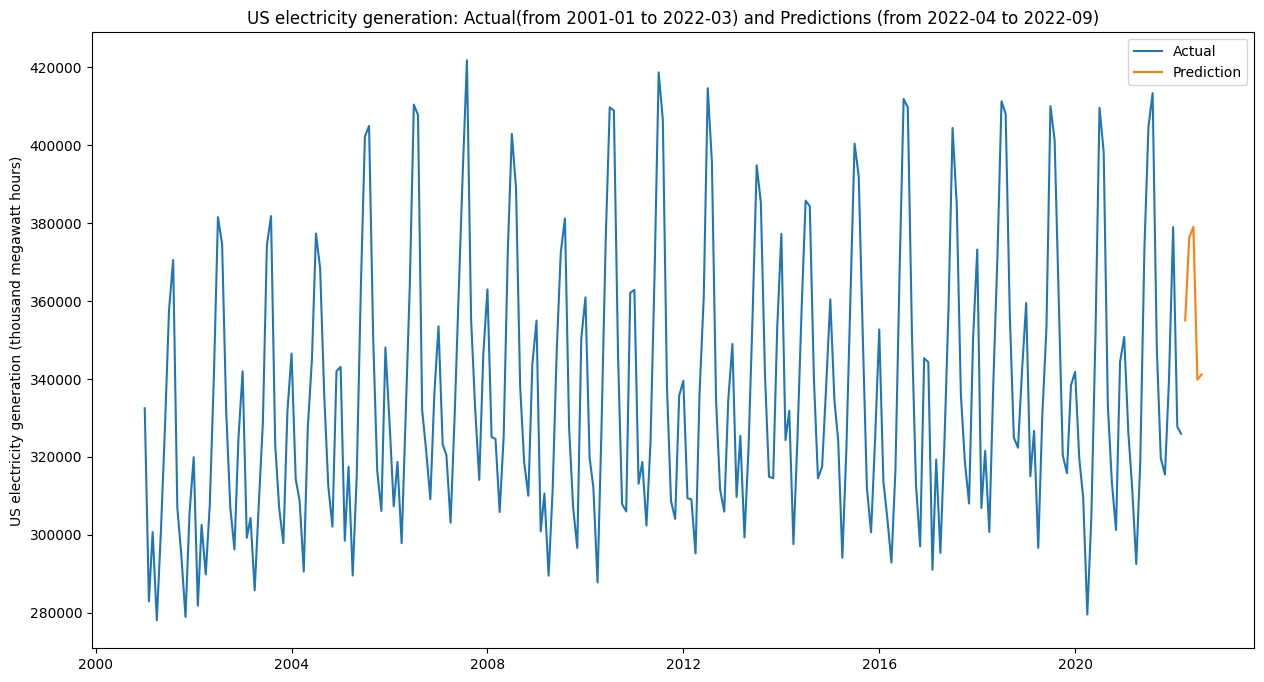

In [55]:
plt.figure(figsize=(15,8))
plt.plot(us_el_selected.index, us_el_selected['United States : all sectors'], label='Actual')
plt.plot(future_month,inverse_future_pred[-windows:], label='Prediction')
plt.title('US electricity generation: Actual(from 2001-01 to 2022-03) and Predictions (from 2022-04 to 2022-09)')
plt.ylabel('US electricity generation (thousand megawatt hours)')
plt.legend()
plt.show()

Source/Reference:

https://www.kaggle.com/datasets/ravishah1/electricity-generation-time-series

https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

https://towardsdatascience.com/time-series-forecasting-with-deep-learning-in-pytorch-lstm-rnn-1ba339885f0c

https://www.kaggle.com/code/tronrover/theory-to-practice-lstm-and-transformers-pytorch#-Transformers-

https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/